## ECE 276 Assignment 1 : Classical Control

## 1  Question 1: 2 DoF Arm

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import gym  # open ai gym
import pybulletgym  # register PyBullet enviroments with open ai gym
import numpy as np
import matplotlib.pyplot as plt
env = gym.make('ReacherPyBulletEnv-v0')
env.reset()  # should return a state vector if everything worked


array([ 0.18377377, -0.15575114, -0.28293938, -0.0182918 , -0.74344255,
       -0.6687998 ,  0.        ,  0.20353142,  0.        ])

### 1.1 Forward Kinematics

In [3]:
l0 = 0.1; l1 = 0.11  #meters

def getForwardModel(q0,q1):
    '''
    Inputs:
    q0, q1 : Robot joint angles

    Return:
    x,y : Position of the end effector

    '''
    l0 = 0.1 #meters
    l1 = 0.11 #meters
 
    x = l0*np.cos(q0) + l1*np.cos(q0 + q1)
    y = l0*np.sin(q0) + l1*np.sin(q0 + q1)

    return x,y   

### 1.2 Jacobian 

In [4]:
def getJacobian(q0,q1):     
    J = np.array([[-l0*np.sin(q0) - l1*np.sin(q0+q1), -l1*np.sin(q0+q1)], \
              [l0*np.cos(q0) + l1*np.cos(q0+q1) ,  l1*np.cos(q0+q1)] \
            ])
    return J

### 1.3 Closed Loop PD-controller on end effector 

In [5]:
def traj(theta): 
    t = np.array([(0.19 + 0.02*np.cos(4*theta)) * np.cos(theta), \
                  (0.19 + 0.02*np.cos(4*theta)) * np.sin(theta)]) 
    return t
traj(np.pi)

array([-2.10000000e-01,  2.57175828e-17])

In [6]:
def PD_Controller(q0, q1, Kp, Kd, a):
    
    # u[k] = Kp*e[k] + Ki sum(e[i], 0 to k) +Kd*(e[k] - e[k-1])
    # since we do not have the intergral(i) part 
    PD = lambda e_k, e_k1, Kp, Kd: Kp*e_k + Kd*(e_k - e_k1)
    
    env = gym.make("ReacherPyBulletEnv-v0")
    env.reset()
    env.unwrapped.robot.central_joint.reset_position(q0, 0)
    env.unwrapped.robot.elbow_joint.reset_position(q1, 0)
    
    E = []
    X = []
    angles = np.linspace(-np.pi, np.pi, 360)
    
    for i, theta in enumerate(np.arange(-np.pi, np.pi, 0.005)):
        
        # To get the current position and angular velocity of q0
        q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
        # To get the current position and angular velocity of q1
        q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()
        
        #get x using the forward model
        x = np.array(getForwardModel(q0,q1))
        x_ref = traj(theta) #sample
        
        e = x_ref - x #error from target
        if i == 0: 
            e_k1 = e #initialize
        
        delta_x = PD(e, e_k1, Kp, Kd) 
        
        J = getJacobian(q0, q1) 
        J_inverse = np.linalg.pinv(J)
        q_temp = np.matmul(J_inverse , delta_x)
        delta_q = q_temp
#         delta_q = (np.pi + q_temp) % (np.pi*2) - np.pi
#         a = 2 #constant parameter for step
        delta_q = a*delta_q
        
        env.step(delta_q)
        E.append(np.linalg.norm(e)) 
        X.append(x)
        e_k1 = e
    return X, E
        

In [7]:
def plot_traj(X, E, Kp, Kd, a, title): 
    
    plt.figure()
#     angles = np.linspace(-np.pi, np.pi, 360)
    angles = np.arange(-np.pi, np.pi, 0.005)
    x = (0.19 + 0.02*np.cos(4*angles)) * np.cos(angles)
    y = (0.19 + 0.02*np.cos(4*angles)) * np.sin(angles)
    plt.plot(x, y, color='b', markersize=1, label='Actual Trajectory')
    
    X = np.array(X)
    plt.plot(X[:, 0], X[:, 1], color = 'r', markersize = 3,label='Robot Trajectory')
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [8]:
# Parameters
Kp = 2
Kd = 2
a = 2

Error:  0.00034474071969920513
Kp = 2    Kd = 2    k = 2


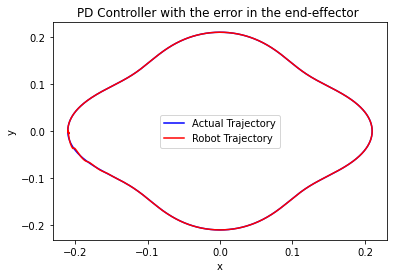

In [9]:
X, E = PD_Controller(np.pi, 0, Kp, Kd, a)
mse_error = np.nanmean(E)
print("Error: ", mse_error)
print(f"Kp = {Kp}    Kd = {Kd}    k = {a}")
plot_traj(X,E,Kp,Kd,a,"PD Controller with the error in the end-effector ")

### 1.4 Inverse Kinematics Solution 
- There is no standard analytical approch to solving IK. One can use iterative approce like the following algorithm. How ever it does not gurantee convergence. 
- The challenges with using analytical IK solution to track trajectories is that there is not one definite answer. The solution can result in infinite, several, a single, or no solution.
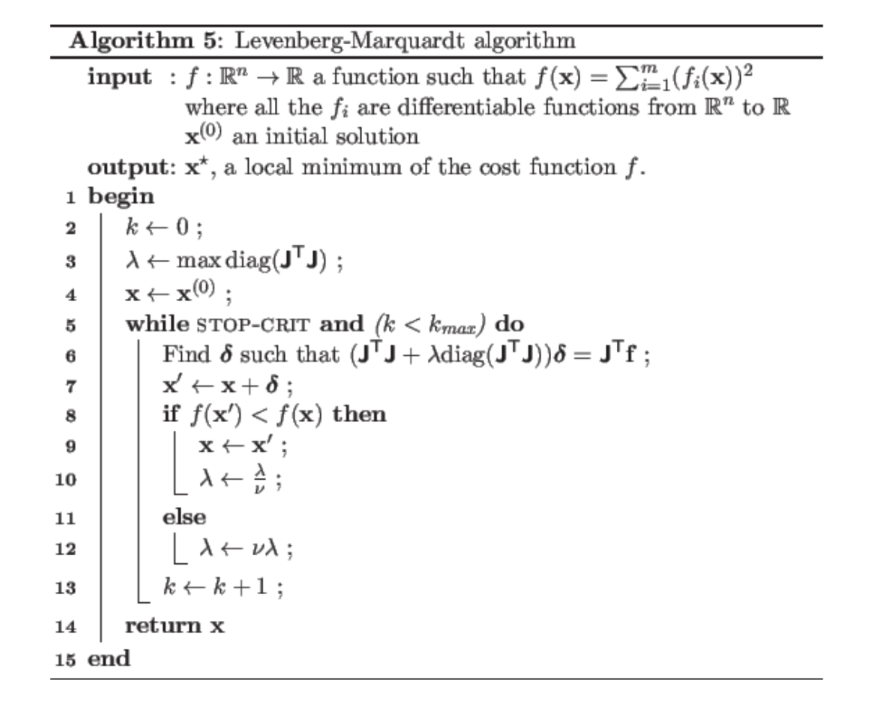

### 1.5 Closed Loop PD-controller on join angle

The main difference between PD controller and the previous PD controller in 1.3 is the error in the joint space instead of the end-effector. And the following parameters: 

X_error = X_reff+ X,

error = $J^{\dagger}$ * X_error 

$\triangle q = K{p} * e[k] + K_{d}*(e[k] - e[k-1])$

Step = q

In [10]:
def PD_Controller(q0, q1, Kp, Kd, a):
    
    # u[k] = Kp*e[k] + Ki sum(e[i], 0 to k) +Kd*(e[k] - e[k-1])
    # since we do not have the intergral(i) part 
    PD = lambda e_k, e_k1, Kp, Kd: Kp*e_k + Kd*(e_k - e_k1)
    
    env = gym.make("ReacherPyBulletEnv-v0")
    env.reset()
    env.unwrapped.robot.central_joint.reset_position(q0, 0)
    env.unwrapped.robot.elbow_joint.reset_position(q1, 0)
    
    E = []
    X = [] 
    angles = np.linspace(-np.pi, np.pi, 360)
    for i, theta in enumerate(angles):
        
        # To get the current position and angular velocity of q0
        q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
        # To get the current position and angular velocity of q1
        q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()
        
        #get x using the forward model
        x = np.array(getForwardModel(q0,q1))
        x_ref = traj(theta) #sample
        
        X_e = x_ref - x #error from target

        
        J = getJacobian(q0, q1) 
        J_inverse = np.linalg.pinv(J)
        q_temp = np.matmul(J_inverse , X_e)
        e = q_temp

        
        if i == 0: 
            e_t1 = e
        
        delta_q = PD(e, e_t1, Kp, Kd)
        
        env.step(delta_q)
        E.append(np.linalg.norm(X_e)) 
        X.append(x)
        e_k1 = e
    return X, E
    

In [11]:
# Parameters
Kp = 3
Kd = 5

Error:  0.00545315194769457
Kp = 3    Kd = 5    k = 2


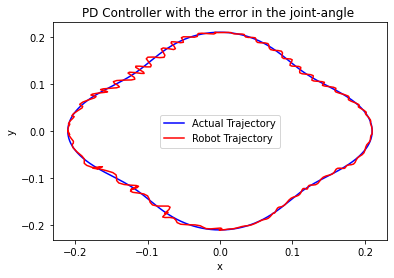

In [12]:
X, E = PD_Controller(np.pi, 0, Kp, Kd,a)
mse_error = np.nanmean(E)
print("Error: ", mse_error)
print(f"Kp = {Kp}    Kd = {Kd}    k = {a}")
plot_traj(X,E,Kp,Kd,a,"PD Controller with the error in the joint-angle ")

### Problem 2 Race Car

In [13]:
from racecar.SDRaceCar import SDRaceCar

In [14]:
track = 'FigureEight' #FigureEight, Linear, Circle
env = SDRaceCar(render_env=True , track=track)
env.reset()

array([-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, array([ 2.50716346, -2.48738583])],
      dtype=object)

action space: [wheel angle, thrust] normalized to be btwn [-1,1]

observation space: [x,y,theta, vx, vy, theta_dot, h] 

- [x,y,theta] - inertial frame position 
- Vx, Vy - velocities 
- theta_dot = angular rotation 
- h = coordinated on the track car has to reach 


## Controller Explanation

In this problem, to be able to follow the path and reach the target as fast as possible, we need to control two things, the direction/the angle and if we are on the path or not (which is basically minimizing the distance betweeen the closest point on the path and the current position.)

My controller does these both steps in the angle_correction() function. It is basically updating the angle towards the end position and moving to the closest point on the path at the same time iteratively. Once we have the update angle, we use that to get the next step in the get_next_step() function.

The results for each env are below with the parameters in the cell above the results. 

In [15]:
def angle_correction(x,y,theta,v,h,k):
    """
    dt - closest point on the path from the car 
    v - 
    """
    dxy = h - np.array([x,y])
    target_angle = np.arctan2(dxy[1], dxy[0])
    theta_temp =  target_angle - theta 
    theta_new = np.arctan2(k * np.sqrt(dxy[0]**2 + dxy[1]**2), v)
    delta = theta_new + theta_temp
    delta = (np.pi + delta) % (np.pi*2)-np.pi
    return delta

def get_next_step(env,Kp,k,T):
    obv = env.get_observation()
    x,y,theta,Vx,Vy,theta_dot,h = obv[0], obv[1], obv[2], \
                              obv[3], obv[4],obv[5],obv[6]
    PATH.append([x,y])
    v = np.linalg.norm(np.array([Vx,Vy]))
#     v =  2.23 * np.sqrt(Vx**2 + Vy**2) 
#     v =  np.sqrt(Vx**2 + Vy**2)
    speed = Kp*(TARGET_SPEED - v)
    wheel_angle_theta = angle_correction(x,y,theta,v,h,k)
    ERROR.append(np.linalg.norm(np.array([x,y]) - env.track[:,env.closest_track_ind]))
    return wheel_angle_theta, speed

def plot_traj(title,PATH): 
    
    plt.figure()
#     angles = np.linspace(-np.pi, np.pi, 360)
    angles = np.arange(-np.pi, np.pi, 0.005)
    x = env.track[0,:]
    y = env.track[1,:]
    plt.plot(x, y, color='b', markersize=1, label='Actual Trajectory')
    
    X = np.array(PATH)
    plt.plot(X[:, 0], X[:, 1], color = 'r', markersize = 3,label='Robot Trajectory')
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

ERROR:  0.37394823953380824
Finished the path: 100%


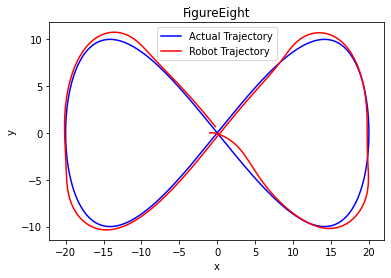

In [16]:
Kp = 4
k = 0.15
TARGET_SPEED = 6.2
PATH = []
ERROR = []
for T in range(400):
    env.step(get_next_step(env,Kp,k,T))

mse_error = np.nanmean(ERROR)
print("ERROR: ", mse_error)
print("Finished the path: {:.0f}%".format((env.closest_track_ind / env.track_len)*100))
plot_traj(track,PATH)

In [17]:
track = 'Linear' #FigureEight, Linear, Circle
env = SDRaceCar(render_env=True , track=track)
env.reset()

array([-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, array([20.0040008,  0.       ])],
      dtype=object)

ERROR:  0.07140491207280524
Finished the path: 99%


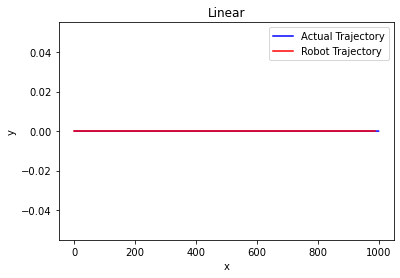

In [18]:
Kp = 6
k = 0
TARGET_SPEED = 89
PATH = []
ERROR = []
for T in range(300):
    env.step(get_next_step(env,Kp,k,T))

mse_error = np.nanmean(ERROR)
print("ERROR: ", mse_error)
print("Finished the path: {:.0f}%".format((env.closest_track_ind / env.track_len)*100))
plot_traj(track,PATH)


In [19]:
track = 'Circle' #FigureEight, Linear, Circle
env = SDRaceCar(render_env=True , track=track)
env.reset()

array([-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, array([1.25358173, 0.0788845 ])],
      dtype=object)

ERROR:  0.08950293780012632
Finished the path: 99%


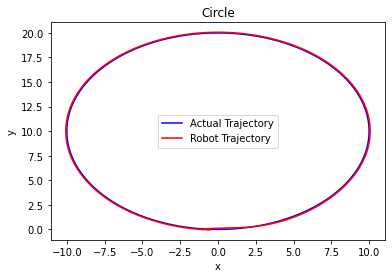

In [20]:
Kp = 3
k = 0.1
TARGET_SPEED = 3.2
PATH = []
ERROR = []
for T in range(350):
    env.step(get_next_step(env,Kp,k,T))

mse_error = np.nanmean(ERROR)
print("ERROR: ", mse_error)
print("Finished the path: {:.0f}%".format((env.closest_track_ind / env.track_len)*100))
plot_traj(track,PATH)